# 2022.9.16
- test 2-stage DCT
    - ok: change model 😞
    - else: change block size 😞 & test on small pics 😏
- fast- speed dct is required 😏
- Add YUV process
- Change background color to black

In [70]:
# google drive
# from google.colab import drive
# drive.mount('/content/drive')
# file address in google drive
file_root = './'

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [72]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights

In [73]:
def pltshow(img,gray=False):
    plt.figure(figsize=(5,5))
    plt.axis('off')
    if(gray):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)
toPIL = transforms.ToPILImage()

In [74]:
def pltshow_yuv(img,gray=False):
    img = cv2.cvtColor(img,cv2.COLOR_YUV2RGB)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(img)

In [120]:
# load and show original image
img = cv2.imread('%sbeagle.jpg'%file_root)
img = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
img = cv2.resize(img,dsize=(img.shape[0],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
# load and show watermark image
wm = cv2.imread('%savatar2.jpg'%file_root)
wm = cv2.cvtColor(wm,cv2.COLOR_BGR2YUV)
# wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)

In [77]:
with tqdm(total=wm.shape[0]*wm.shape[1]) as pbar:
    pbar.set_description('Change Processing')
    for w in range(wm.shape[0]):
        for h in range(wm.shape[1]):
            if (wm[w][h] == [255,128,128]).all():
                wm[w][h] = [0,128,128]
            pbar.update(1)


Change Processing: 100%|██████████| 34886742/34886742 [01:52<00:00, 309820.24it/s]


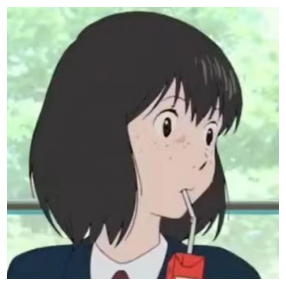

In [121]:
pltshow_yuv(wm)

In [16]:
# image tranformation
T_3 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
T_2 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([256,256])
])
T = transforms.ToTensor()


In [111]:
# add border to image so that it can be divided perfectly with block_size
def addborder(img,block_size=8):
    diff_x = img.shape[0] % block_size
    diff_y = img.shape[1] % block_size
    if (diff_x==0 and diff_y==0):
        return img
    img = cv2.copyMakeBorder(img,
              0,(block_size-diff_x),
              0,(block_size-diff_y),
              cv2.BORDER_REPLICATE)
    return img

In [122]:
img = addborder(img)
img_tensor = T(img).cuda()
wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
wm_tensor = T(wm).cuda()

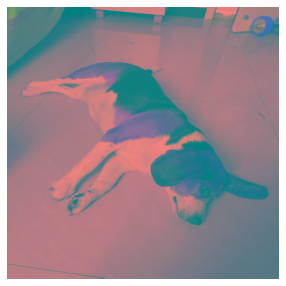

In [81]:
pltshow(toPIL(img_tensor))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


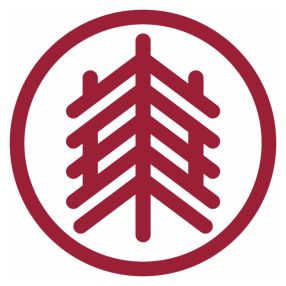

In [113]:
pltshow_yuv_tensor(wm_tensor)

In [24]:
wm_tensor[0,w,h]

tensor(1., device='cuda:0')

In [87]:
from torch import Tensor
from torchvision.models.resnet import ResNet
from torch import nn
from typing import Optional, Any, List, Callable, Type, Union
from torchvision.models.resnet import BasicBlock,Bottleneck
class ResNet_with_trans(ResNet):
    def forward(self, x: Tensor) -> Tensor:
        x = transforms.Resize([256,256])(x)
        x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(x)
        return self._forward_impl(x)

from torchvision.models.resnet import ResNet50_Weights
from torchvision.models._utils import _ovewrite_named_param
def resnet50_with_trans(*, weights: Optional[ResNet50_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    weights = ResNet50_Weights.verify(weights)
    # model = _resnet(Bottleneck, [3, 4, 6, 3], weights, progress, **kwargs)
    block = Bottleneck
    layers = [3, 4, 6, 3]

    if weights is not None:
        _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))

    model = ResNet_with_trans(block, layers, **kwargs)

    if weights is not None:
        model.load_state_dict(weights.get_state_dict(progress=progress))
    
    return model

In [88]:
resnet = resnet50_with_trans(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet = resnet.cuda()
resnet = resnet.eval()

In [85]:
# check classification result for single image
# param model: torch model
# param img: 4-dim image tensor
def check_classify(model,img):
    img = torch.unsqueeze(img,0).type(torch.FloatTensor).cuda()
    out = (F.softmax(model(img),dim=1))
    print(torch.max(out))
    print(out.argmax())

In [89]:
check_classify(resnet,img_tensor)

tensor(0.3331, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(701, device='cuda:0')


In [56]:
target = torch.tensor([162]).cuda()

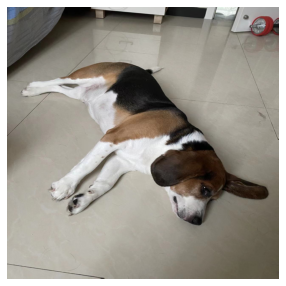

In [42]:
pltshow(toPIL(img_tensor))

In [90]:
def block_dct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_dct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
# with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
#     pbar.set_description('DCT Processing')
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_dct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.dct(a_block)
            # pbar.update(1)
    return torch.from_numpy(img_dct).cuda()

def block_idct(bk,block_size=8):
    img_dct_blocks_h = bk.shape[0] // block_size
    img_dct_blocks_w = bk.shape[1] // block_size
    img_idct = np.zeros(shape = (bk.shape[0],bk.shape[1]))
# with tqdm(total=img_dct_blocks_h*img_dct_blocks_w) as pbar:
#     pbar.set_description('IDCT Processing')
    for h in range(img_dct_blocks_h):
        for w in range(img_dct_blocks_w):
            a_block = bk[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size]
            img_idct[h*block_size:(h+1)*block_size,w*block_size:(w+1)*block_size] =\
            cv2.idct(a_block)
            # pbar.update(1)
    return torch.from_numpy(img_idct).cuda()

def dct_tensor(img,block_size=8):
    img = img.cpu().numpy()
    if img.ndim == 2:
        return block_dct(img,block_size)
    elif img.shape[0] == 1:
        return block_dct(img[0,...],block_size)
    else:
        return torch.stack((block_dct(img[0,...],block_size),block_dct(img[1,...],block_size),block_dct(img[2,...],block_size)),dim=0)

def idct_tensor(img,block_size=8):
    img = img.cpu().numpy()
    if img.ndim == 2:
        return block_idct(img,block_size)
    elif img.shape[0] == 1:
        return block_idct(img[0,...],block_size)
    else:
        return torch.stack((block_idct(img[0,...],block_size),block_idct(img[1,...],block_size),block_idct(img[2,...],block_size)),dim=0)

def embed_wm(img,wm,alpha,block_size=8):
    img_dct = dct_tensor(img,block_size)
    img_dct_wm = img_dct + alpha*wm
    img_wm_idct = idct_tensor(img_dct_wm,block_size)
    wmed_img = img_wm_idct.clip(0,1)
    return wmed_img

def extract_wm(img,wmed_img,alpha,block_size=8):
    img_dct = dct_tensor(img,block_size)
    wmed_dct = dct_tensor(wmed_img,block_size)
    wm = (wmed_dct-img_dct)/alpha
    return wm

In [44]:
import torch_dct as dct

In [45]:
img = addborder(img,4)
img_tensor = T(img).cuda()
wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
wm_tensor = T(wm).cuda()

In [105]:
def pltshow_yuv_tensor(img):
    img = img.type(torch.float32)
    img = img.permute(1, 2, 0).cpu().numpy()
    img = cv2.cvtColor(img,cv2.COLOR_YUV2RGB)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


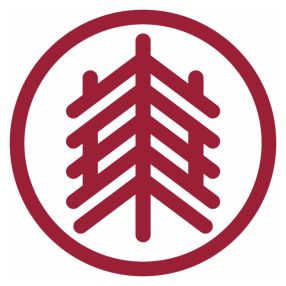

In [118]:
pltshow_yuv_tensor(wm_tensor.clip(0.,1.))

In [123]:
%%time
alpha = 0.05
wmed = embed_wm(img_tensor,wm_tensor,alpha,8)

CPU times: user 734 ms, sys: 8.46 ms, total: 743 ms
Wall time: 755 ms


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


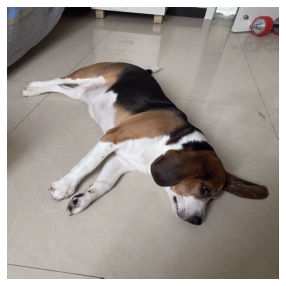

In [124]:
pltshow_yuv_tensor(wmed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


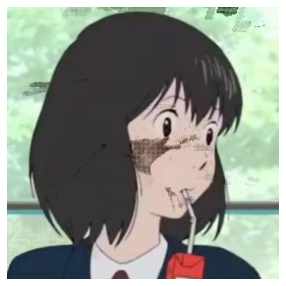

In [127]:
ext_wm = extract_wm(img_tensor,wmed,alpha)
pltshow_yuv_tensor(ext_wm)

In [55]:
wmed_np_rgb = cv2.cvtColor(img,cv2.COLOR_YUV2RGB)

In [56]:
nptest = img_tensor.permute(1, 2, 0).cpu().numpy()

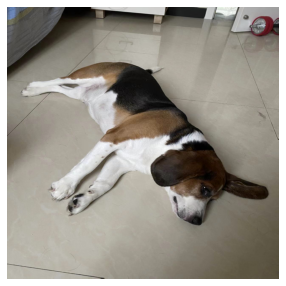

In [57]:
pltshow(wmed_np_rgb)

In [57]:
import torchattacks
beta = 1/255
pgd_atk = torchattacks.PGD(resnet, eps=8/255, alpha=beta, steps=40, random_start=True)
wmed_input = torch.unsqueeze(wmed,0).type(torch.FloatTensor)
adv_images = pgd_atk(wmed_input, target)
out_per = (F.softmax(resnet(adv_images),dim=1))
print(torch.max(out_per))
print(out_per.argmax())
pgd_wmed = adv_images[0,...]

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


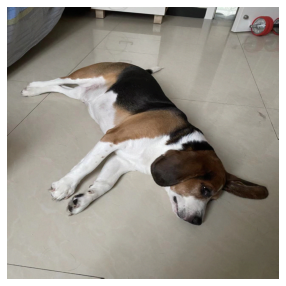

In [58]:
pltshow(toPIL(pgd_wmed))

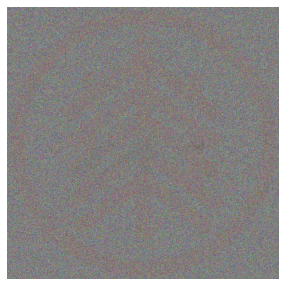

In [59]:
pltshow(toPIL(extract_wm(img_tensor,pgd_wmed,alpha)))

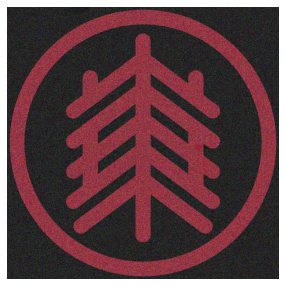

In [60]:
pgd_per = (pgd_wmed-wmed)/beta
per_dct = dct_tensor(pgd_per)

wm_per = per_dct * (beta/alpha)

wm_perturbed = (wm_per+wm_tensor).clip(0,1)

pltshow(toPIL(wm_perturbed))

In [61]:
adv_wm_test = embed_wm(img_tensor,wm_perturbed,alpha)
check_classify(resnet,adv_wm_test)

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


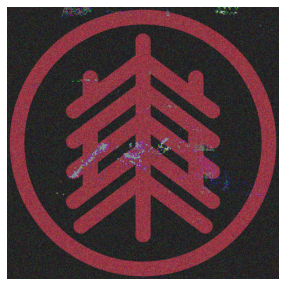

In [62]:
pltshow(toPIL(extract_wm(img_tensor,adv_wm_test,alpha)))

In [97]:
wm_extract = extract_wm(img_tensor,wmed,alpha)

In [98]:
wm_adv_origin = extract_wm(img_tensor,pgd_wmed,alpha)

In [99]:
wm_adv_new = extract_wm(img_tensor,adv_wm_test,alpha)

In [70]:
from torch import norm

In [101]:
idct_wm = idct_tensor(wm_tensor)

In [102]:
dct_per = dct_tensor(pgd_per)

In [63]:
def alpha_update(alpha,beta,l1,l2,step,idct_wm,per,dct_per):
    grad = l1*norm(alpha*idct_wm+beta*per)*norm(idct_wm)-l2*(beta/alpha**2)*norm(dct_per)
    alpha_new = alpha - step*alpha
    if alpha_new < 0:
        alpha_new = alpha
    return alpha_new

In [105]:
a_test = alpha_update(alpha,beta,l1,l2,s_a,idct_wm,pgd_per,dct_per)

In [107]:
b_test = beta_update(alpha,beta,l1,l2,s_b,idct_wm,pgd_per,dct_per)

In [66]:
def check_out(model,img,target):
    img = torch.unsqueeze(img,0).type(torch.FloatTensor).cuda()
    out = (F.softmax(model(img),dim=1))
    out = out.argmax()
    return (out == target).item()

In [86]:
def opti(img,wm,model,atk,target,N,alpha,beta,l1,l2,s_a,s_b):
    wmed_origin = embed_wm(img,wm,alpha)
    wmed_input = torch.unsqueeze(wmed_origin,0).type(torch.FloatTensor).cuda()
    adv_images = atk(wmed_input, target)
    adv_wmed_origin = adv_images[0,...]
    per = (adv_wmed_origin-wmed_origin)/beta
    per_dct = dct_tensor(per)
    wm_per = per_dct * (beta/alpha)
    wm_perturbed = (wm_per+wm).clip(0,1)
    wmed = embed_wm(img,wm_perturbed,alpha)
    idct_wm = idct_tensor(wm)
    dct_per = dct_tensor(per)
    wm_res = wm_perturbed
    wmed_res = wmed
    with tqdm(total=N) as pbar:
        pbar.set_description('Optimization Processing')
        for n in range(N):
            alpha_new = alpha_update(alpha,beta,l1,l2,s_a,idct_wm,per,dct_per)
            beta_new = beta_update(alpha,beta,l1,l2,s_b,idct_wm,per,dct_per)
            wm_perturbed = (wm + (beta_new/alpha_new)*dct_per).clip(0,1)
            wmed = embed_wm(img,wm_perturbed,alpha_new)
            if check_out(model,wmed,target):
                return wm_res,wmed_res,alpha,beta
            else:
                alpha = alpha_new
                beta = beta_new
                wm_res = wm_perturbed
                wmed_res = wmed
            pbar.update(1)   
        return wm_res,wmed_res,alpha,beta

In [65]:
def beta_update(alpha,beta,l1,l2,step,idct_wm,per,dct_per):
    grad = l1*norm(alpha*idct_wm+beta*per)*norm(per)+l2*(1/alpha)*norm(dct_per)
    beta_new = beta - step*beta
    if beta_new < 0:
        beta_new = beta
    return beta_new

In [84]:
alpha = 0.5
beta = 1/255
l1 = 0.001
l2 = 0.001
s_a = 0.1
s_b = 0.1
N=10

In [87]:
wm_res, wmed_res,alpha,beta = opti(img_tensor,wm_tensor,resnet,pgd_atk,target,N,alpha,beta,l1,l2,s_a,s_b)

Optimization Processing: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


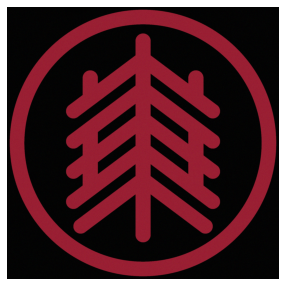

In [88]:
pltshow(toPIL(wm_res))

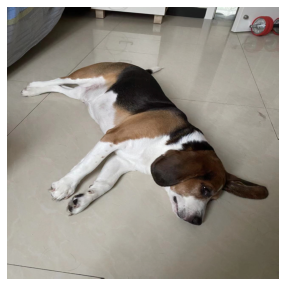

In [89]:
pltshow(toPIL(wmed_res))

In [91]:
check_classify(resnet,wmed_res)

tensor(0.3635, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(171, device='cuda:0')


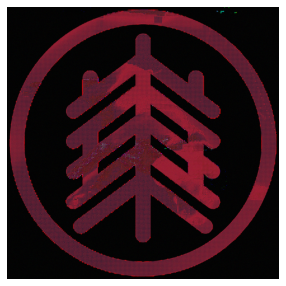

In [92]:
pltshow(toPIL(extract_wm(img_tensor,wmed_res,alpha)))

In [93]:
check_classify(resnet,img_tensor)

tensor(0.8058, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(162, device='cuda:0')


In [94]:
minist_ds = torchvision.datasets.MNIST('%sdataset'%file_root,download=True)

In [95]:
minist_ds[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FB4EC373220>, 5)

In [96]:
minist_ds[0][0]

In [99]:
minist_test = transforms.ToTensor()(minist_ds[0][0])

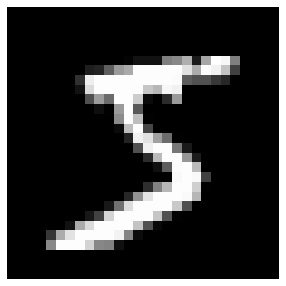

In [101]:
pltshow(toPIL(minist_test),gray=True)

CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 233 ms


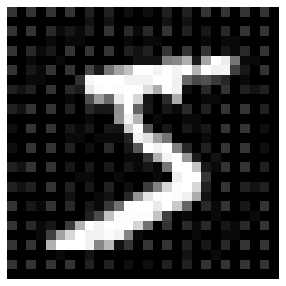

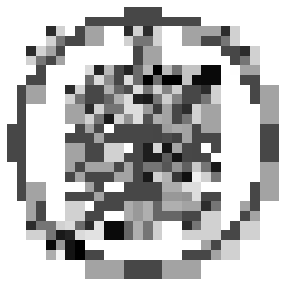

In [142]:
%%time
# load and show original image
minist_tensor = transforms.ToTensor()(minist_ds[0][0])
wm_gray = cv2.imread('%secnu3.png'%file_root,0)
# wm = cv2.resize(wm,dsize=(img.shape[1],img.shape[0]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
wm_gray = cv2.resize(wm_gray,dsize=(minist_tensor.shape[2],minist_tensor.shape[1]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
wm_gray_tensor = T(wm_gray).cuda()
alpha = 0.1
wmed_minist = embed_wm(minist_tensor,wm_gray_tensor,alpha,2)

pltshow(toPIL(wmed_minist),gray=True)

pltshow(toPIL(extract_wm(minist_tensor,wmed_minist,alpha,2)),gray=True)

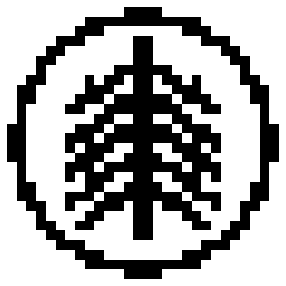

In [140]:
pltshow(toPIL(wm_gray),gray=True)

In [95]:
cifar10_ds = torchvision.datasets.CIFAR10('%sdataset'%file_root,download=True)

Files already downloaded and verified


CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 39.1 ms


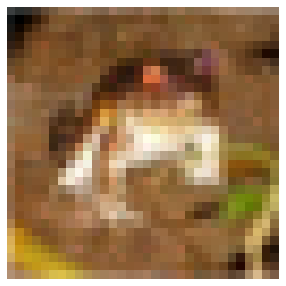

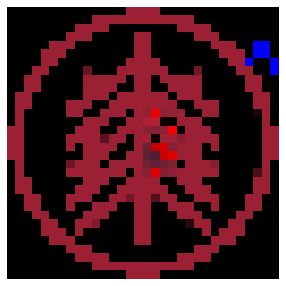

In [96]:
%%time
# load and show original image
cifar_tensor = transforms.ToTensor()(cifar10_ds[0][0])
# wm = cv2.imread('%secnu3.png'%file_root)
wm = cv2.resize(wm,dsize=(cifar_tensor.shape[2],cifar_tensor.shape[1]),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
# wm = cv2.cvtColor(wm,cv2.COLOR_BGR2RGB)
wm_tensor = T(wm).cuda()
alpha = 0.05
wmed_cifar = embed_wm(cifar_tensor,wm_tensor,alpha,4)

pltshow(toPIL(wmed_cifar))

pltshow(toPIL(extract_wm(cifar_tensor,wmed_cifar,alpha,4)))

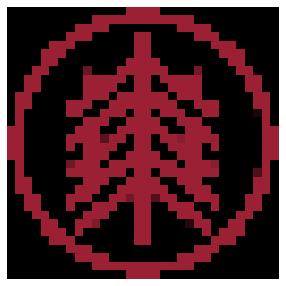

In [97]:
pltshow(toPIL(wm_tensor))

In [98]:
wmed_pil = toPIL(wmed)

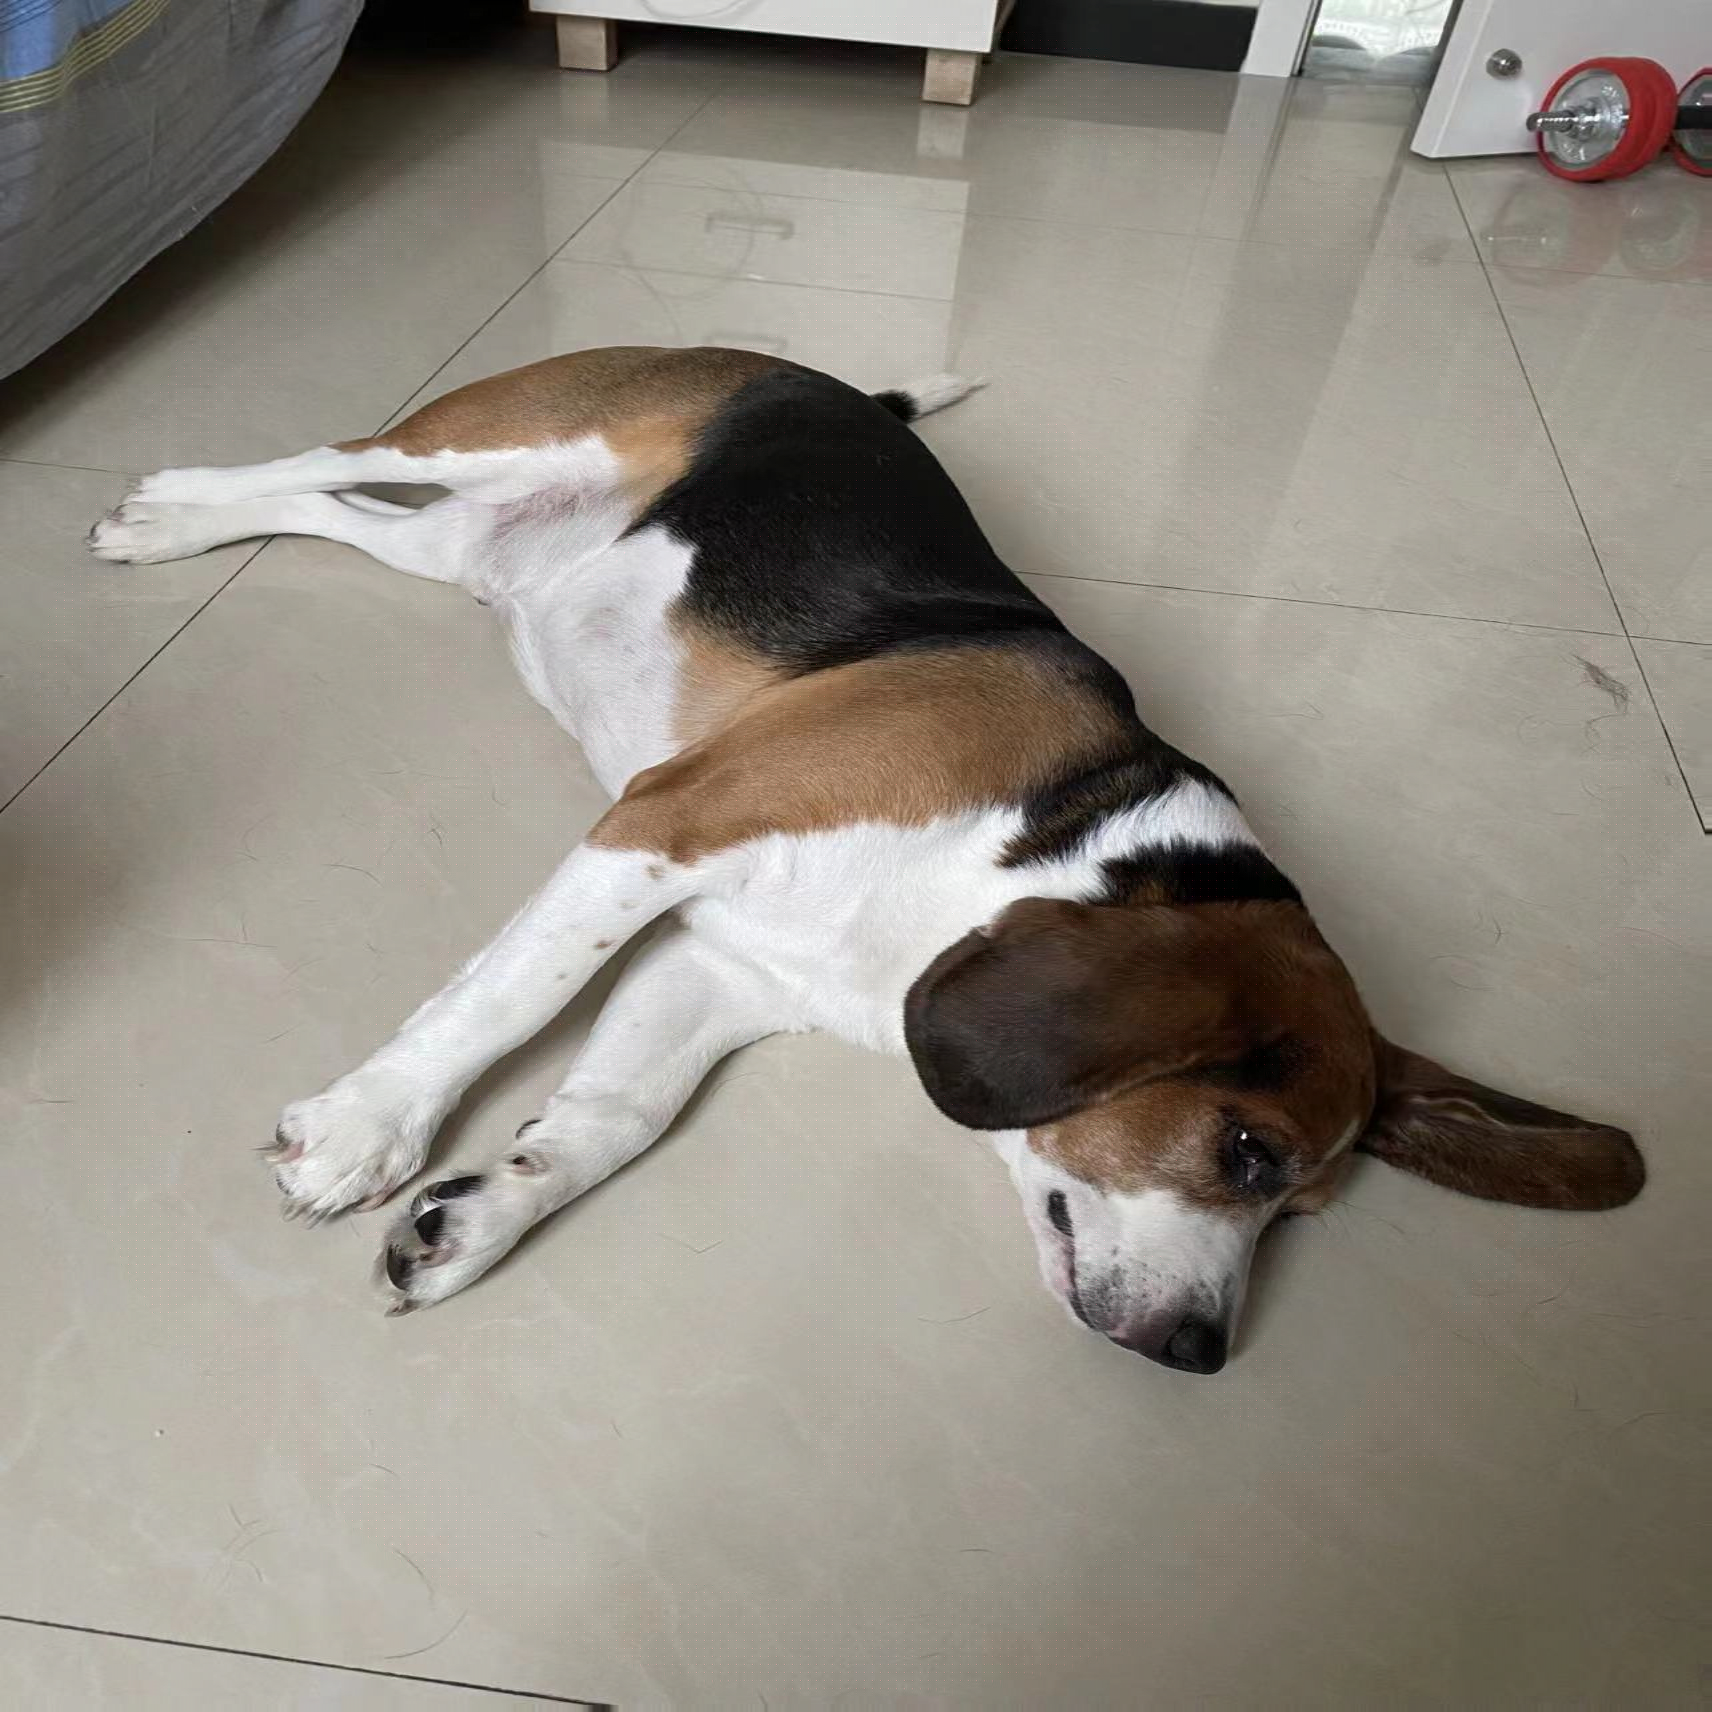

In [99]:
wmed_pil

In [100]:
wmed_pil_tensor = T(wmed_pil).cuda()

In [101]:
ex = extract_wm(img_tensor,wmed_pil_tensor,alpha)

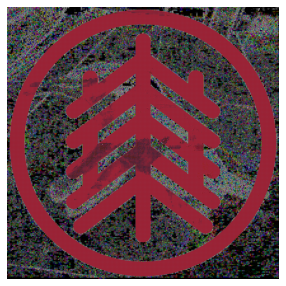

In [102]:
pltshow(toPIL(ex))